In [27]:
#!pip install lckr-jupyterlab-variableinspector


In [1]:
import xarray as xr
import numpy as np

import xoak

from matplotlib import pyplot as plt
import parcels

In [2]:
from pathlib import Path
FESOM_data_path = Path("/gxfs_work/geomar/smomw662/fesom_parcels_001/data")

In [4]:
pwd

'/gxfs_work/geomar/smomw662/fesom_parcels_001/data'

In [3]:
FESOM_data_path

PosixPath('/gxfs_work/geomar/smomw662/fesom_parcels_001/data')

### Create a Fieldset

In [5]:
FESOM2_data = FESOM_data_path/"channel"

In [23]:
## u.fesom.1958.nc  
## v.fesom.1978.nc
## w.fesom.2008.nc
# filenames = {
#     "U": FESOM2_data / "u*.nc",
#     "V": FESOM2_data / "v*.nc",
#     "W": FESOM2_data / "w*.nc"
# }

In [36]:
# variables = {
#     "U": "eastward_current_velocity",
#     "V": "northward_current_velocity",
#     "W": "upward_current_velocity"
# }
# #dimensions = {"depth": "nz1", "time": "time", "u": "u"}
# dimensions = {"depth": "nz1", "time": "time"}

In [ ]:
# fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

In [6]:
ds_mesh = xr.open_dataset(f'{FESOM2_data}/fesom.mesh.diag.nc')
#ds_mesh = xr.open_dataset(f'{FESOM2_data}/"fesom.mesh.diag.nc")
ds_mesh = ds_mesh.set_coords(["lat", "lon"])
ds_mesh = ds_mesh.assign_coords(node_id=(("nod2", ), range(ds_mesh.sizes["nod2"])))
print(ds_mesh)

<xarray.Dataset> Size: 9MB
Dimensions:            (nz: 41, nz1: 40, elem: 21120, nod2: 10608, n3: 3,
                        n2: 2, edg_n: 31728, N: 6, n4: 4)
Coordinates:
  * nz                 (nz) float64 328B 0.0 9.038 18.98 ... 3.628e+03 4e+03
  * nz1                (nz1) float64 320B 4.519 14.01 ... 3.459e+03 3.814e+03
    lon                (nod2) float64 85kB ...
    lat                (nod2) float64 85kB ...
    node_id            (nod2) int64 85kB 0 1 2 3 4 ... 10604 10605 10606 10607
Dimensions without coordinates: elem, nod2, n3, n2, edg_n, N, n4
Data variables: (12/19)
    fesom_mesh         int32 4B ...
    elem_area          (elem) float64 169kB ...
    nlevels_nod2D      (nod2) int32 42kB ...
    nlevels            (elem) int32 84kB ...
    nod_in_elem2D_num  (nod2) int32 42kB ...
    nod_part           (nod2) int32 42kB ...
    ...                 ...
    face_links         (n3, elem) float64 507kB ...
    edge_face_links    (n2, edg_n) float64 508kB ...
    nod_in_ele

In [7]:
lon_bds = (ds_mesh.lon.min().data[()], np.ceil(ds_mesh.lon.max().data[()]))
lat_bds = (ds_mesh.lat.min().data[()], np.ceil(ds_mesh.lat.max().data[()]))

In [8]:
print(lon_bds, lat_bds)

(0.0, 5.0) (0.0, 18.0)


In [9]:
lon_grid = xr.DataArray(np.linspace(*lon_bds, 101), dims=("lon_grid", ), name="lon_grid")
lat_grid = xr.DataArray(np.linspace(*lat_bds, 101), dims=("lat_grid", ), name="lat_grid")
lon_grid_selector, lat_grid_selector = xr.broadcast(lon_grid, lat_grid)

In [10]:
ds_mesh.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")

nodes_grid = ds_mesh.xoak.sel(lon=lon_grid_selector, lat=lat_grid_selector).node_id

nodes_grid = nodes_grid.rename({"lon": "lon_fesom", "lat": "lat_fesom"})

nodes_grid = nodes_grid.assign_coords(lon_grid=lon_grid, lat_grid=lat_grid)

display(nodes_grid)

<xarray.DataArray 'node_id' (lon_grid: 101, lat_grid: 101)> Size: 82kB
array([[    0,     2,     4, ...,   217,   219,   220],
       [  221,   223,     5, ...,   217,   219,   441],
       [  221,   223,   225, ...,   438,   440,   441],
       ...,
       [10388, 10390, 10392, ..., 10604, 10606, 10606],
       [10388, 10390, 10392, ..., 10604, 10606, 10606],
       [10388, 10390, 10392, ..., 10604, 10606, 10606]])
Coordinates:
    lon_fesom  (lon_grid, lat_grid) float64 82kB 0.0 0.0 0.0 ... 4.453 4.453
    lat_fesom  (lon_grid, lat_grid) float64 82kB 0.0 0.1628 ... 17.82 17.82
    node_id    (lon_grid, lat_grid) int64 82kB 0 2 4 6 ... 10604 10606 10606
  * lon_grid   (lon_grid) float64 808B 0.0 0.05 0.1 0.15 ... 4.85 4.9 4.95 5.0
  * lat_grid   (lat_grid) float64 808B 0.0 0.18 0.36 0.54 ... 17.64 17.82 18.0

In [11]:
data_fesom = (
    np.cos(7 * np.deg2rad(ds_mesh.lon))
    * np.sin(5 * np.deg2rad(ds_mesh.lat))
    * xr.DataArray(np.random.normal(size=(365, )), dims=("t", ))
).drop_vars(["lon", "lat"])

data_fesom

<xarray.DataArray (nod2: 10608, t: 365)> Size: 31MB
array([[ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.0070139 , -0.00153861,  0.0066072 , ...,  0.0025844 ,
         0.00209263, -0.00821554],
       [ 0.01402768, -0.00307719,  0.01321429, ...,  0.00516875,
         0.00418522, -0.01643093],
       ...,
       [ 0.84755004, -0.18592334,  0.79840543, ...,  0.3122953 ,
         0.25287041, -0.99275415],
       [ 0.84474974, -0.18530905,  0.79576751, ...,  0.31126348,
         0.25203493, -0.9894741 ],
       [ 0.84773537, -0.185964  ,  0.79858002, ...,  0.31236359,
         0.25292571, -0.99297123]])
Coordinates:
    node_id  (nod2) int64 85kB 0 1 2 3 4 5 ... 10603 10604 10605 10606 10607
Dimensions without coordinates: nod2, t

In [13]:
data_grid = data_fesom.isel(nod2=nodes_grid)
data_grid

<xarray.DataArray (lon_grid: 101, lat_grid: 101, t: 365)> Size: 30MB
array([[[ 0.        , -0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ],
        [ 0.01402768, -0.00307719,  0.01321429, ...,  0.00516875,
          0.00418522, -0.01643093],
        [ 0.02804391, -0.00615187,  0.02641781, ...,  0.01033329,
          0.00836703, -0.03284846],
        ...,
        [ 0.9869638 , -0.21650592,  0.92973538, ...,  0.36366485,
          0.29446514, -1.15605257],
        [ 0.98727923, -0.21657512,  0.93003252, ...,  0.36378107,
          0.29455925, -1.15642204],
        [ 0.98737855, -0.21659691,  0.93012608, ...,  0.36381767,
          0.29458888, -1.15653839]],

       [[ 0.        , -0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ],
        [ 0.01402676, -0.00307699,  0.01321343, ...,  0.00516842,
          0.00418495, -0.01642985],
        [ 0.03505382, -0.0076896 ,  0.03302125, ...,  0.01291622,
          0.01045847, -0.04105931],
...
        [ 0.84447985, -0.18524985,  0.79551327, ...,  0.31116404,
          0.25195441, -0.98915797],
        [ 0.84474974, -0.18530905,  0.79576751, ...,  0.31126348,
          0.25203493, -0.9894741 ],
        [ 0.84474974, -0.18530905,  0.79576751, ...,  0.31126348,
          0.25203493, -0.9894741 ]],

       [[ 0.00600133, -0.00131649,  0.00565335, ...,  0.0022113 ,
          0.00179052, -0.00702949],
        [ 0.01800279, -0.00394919,  0.01695891, ...,  0.00663346,
          0.00537121, -0.02108706],
        [ 0.02999324, -0.00657949,  0.0282541 , ...,  0.01105156,
          0.00894862, -0.03513175],
        ...,
        [ 0.84447985, -0.18524985,  0.79551327, ...,  0.31116404,
          0.25195441, -0.98915797],
        [ 0.84474974, -0.18530905,  0.79576751, ...,  0.31126348,
          0.25203493, -0.9894741 ],
        [ 0.84474974, -0.18530905,  0.79576751, ...,  0.31126348,
          0.25203493, -0.9894741 ]]])
Coordinates:
    node_id    (lon_grid, lat_grid) int64 82kB 0 2 4 6 ... 10604 10606 10606
    lon_fesom  (lon_grid, lat_grid) float64 82kB 0.0 0.0 0.0 ... 4.453 4.453
    lat_fesom  (lon_grid, lat_grid) float64 82kB 0.0 0.1628 ... 17.82 17.82
  * lon_grid   (lon_grid) float64 808B 0.0 0.05 0.1 0.15 ... 4.85 4.9 4.95 5.0
  * lat_grid   (lat_grid) float64 808B 0.0 0.18 0.36 0.54 ... 17.64 17.82 18.0
Dimensions without coordinates: t

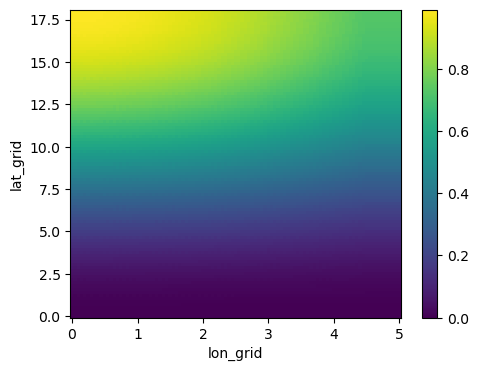

In [14]:
data_grid.var("t").plot.imshow(x="lon_grid", y="lat_grid", size=4)